In [181]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter, tol=1e-6, start_rank=100):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_old = sparse.csr_matrix(self.X.shape)
        self.S_old = np.zeros((self.rank,))
        self.U_old = np.zeros((self.X.shape[0], self.rank))
        self.Vt_old = np.zeros((self.rank, self.X.shape[1]))
        
        self.filled = []
        
        for l in self.lambdas:
            for i in range(maxiter):
                proj_data = np.array(self.Z_old[self.nonzero]).flatten()
                self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), shape=self.X.shape)
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                S -= l
                S = S[S > 0]
                
                #print(S.size, S.min())
                self.rank = S.shape[0]
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                self.U_old = U
                self.Vt_old = Vt
                self.S_old = S
                self.Z_new = U.dot(np.diag(S).dot(Vt))
                # TODO: compute Frobenius norm with no explicit computations of Z
                if (np.linalg.norm(self.Z_new - self.Z_old) ** 2 / np.linalg.norm(self.Z_new) ** 2 < self.tol):
                    self.Z_old = self.Z_new
                    print('converged')
                    break
                self.Z_old = self.Z_new
            self.filled.append(self.Z_old)
        
        return self.lambdas, self.filled

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U_old.dot(np.diag(self.S_old).dot(self.Vt_old.dot(vec)))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt_old.T.dot(np.diag(self.S_old).dot(self.U_old.T.dot(vec)))
        return res


In [84]:
# diagonal init
diags = np.arange(-5, 6, 10)
X = sparse.diags(diagonals=np.ones(diags.size), offsets=diags, shape=(100, 100))
X

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 190 stored elements (2 diagonals) in DIAgonal format>

In [113]:
# random init
np.random.seed(25)
row_ind = np.random.randint(0, 100, size=1000)
col_ind = np.random.randint(0, 100, size=1000)

row_ind = np.append(row_ind, np.arange(100))
col_ind = np.append(col_ind, np.arange(100))

X = sparse.csr_matrix((np.ones(row_ind.size), (row_ind, col_ind)), shape=(100, 100))

X[X > 1] = 1

In [114]:
X.max()

1.0

In [115]:
soft_input = SoftInput(X)

In [116]:
lambdas = np.linspace(0, 0.5, 10)
print(lambdas)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=200, start_rank=50, tol=1e-6)

[ 0.          0.05555556  0.11111111  0.16666667  0.22222222  0.27777778
  0.33333333  0.38888889  0.44444444  0.5       ]
converged
converged


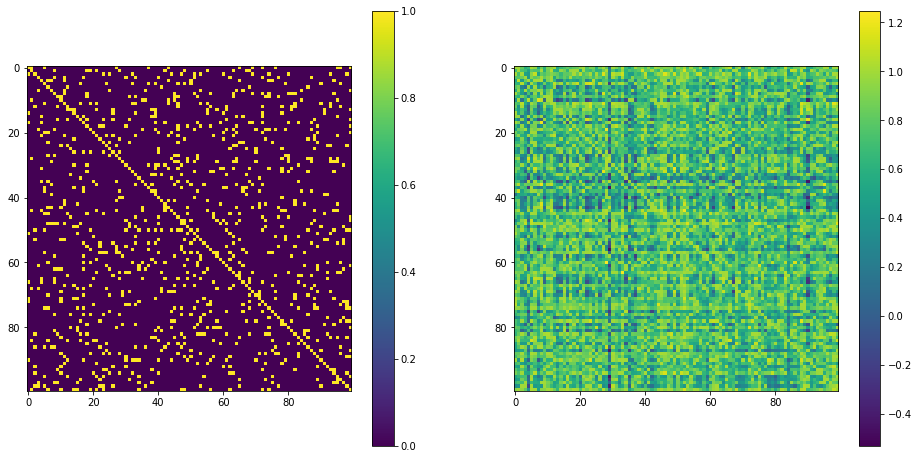

In [117]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(approximations[-1])
plt.colorbar()
plt.show()

In [118]:
np.linalg.matrix_rank(approximations[-1])

15

## Block matrix example ##

In [119]:
import matplotlib.pyplot as plt
from PIL import Image

In [120]:
img = np.array(Image.open('test.png'), dtype=np.float64)[:, :, 0]

In [121]:
img[img == 0] = 100

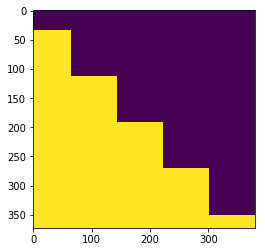

In [122]:
plt.imshow(img)
plt.show()

In [173]:
rows = np.array([], dtype=np.int)
cols = np.array([], dtype=np.int)

k_vals = np.array([-100, -50, -25, -10, -5, 0, 5, 10, 25, 50, 100, 1, 2, 3, -1, -2, -3], dtype=np.int)

for k in k_vals:
    A = sparse.eye(m=img.shape[0], n=img.shape[1], k=k)
    rows_ind, cols_ind = A.nonzero()
    rows = np.append(rows, rows_ind)
    cols = np.append(cols, cols_ind)
    
X = sparse.csr_matrix((img[(rows, cols)], (rows, cols)), shape=img.shape)

In [174]:
X[X == 100]

matrix([[ 100.,  100.,  100., ...,  100.,  100.,  100.]])

In [175]:
# random init
num = img.size // 10

np.random.seed(25)
row_ind = np.random.randint(0, img.shape[0], size=num)
col_ind = np.random.randint(0, img.shape[1], size=num)

row_ind = np.append(row_ind, np.arange(100))
col_ind = np.append(col_ind, np.arange(100))

X = sparse.csr_matrix((img[(row_ind, col_ind)], (row_ind, col_ind)), shape=img.shape)

for i in range(1, 5):
    X[X == 100 * i] = 100
    X[X == 255 * i] = 255

In [178]:
X.max()

255.0

In [183]:
soft_input = SoftInput(X)

In [184]:
lambdas = np.linspace(0, 100, 10)
print(lambdas)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=2000, start_rank=100, tol=1e-6)

[   0.           11.11111111   22.22222222   33.33333333   44.44444444
   55.55555556   66.66666667   77.77777778   88.88888889  100.        ]
converged
converged
converged
converged
converged
converged


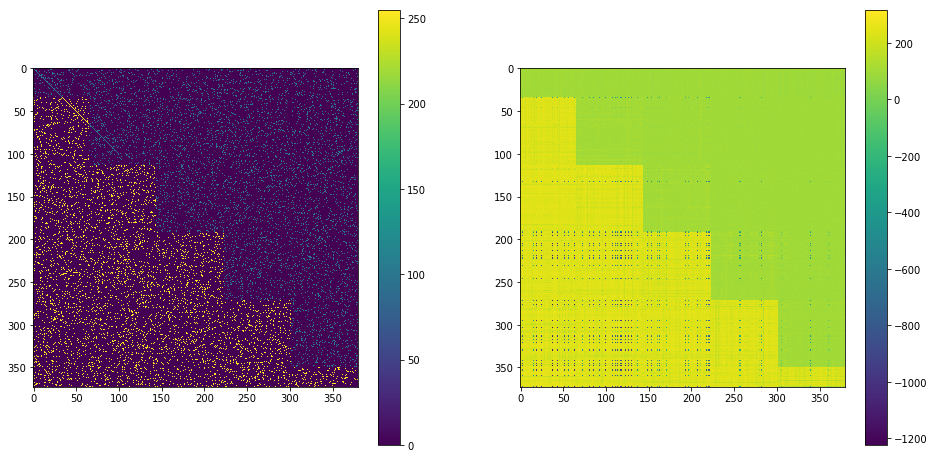

In [190]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(approximations[-1])
plt.colorbar()
plt.show()

In [189]:
np.linalg.matrix_rank(approximations[0])

60